In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv("/content/train.csv")
df_mapping = pd.read_csv("/content/misconception_mapping.csv")

In [ ]:
df_train.head()

,QuestionId,ConstructId,ConstructName,SubjectId,SubjectName,CorrectAnswer,QuestionText,AnswerAText,AnswerBText,AnswerCText,AnswerDText,MisconceptionAId,MisconceptionBId,MisconceptionCId,MisconceptionDId
0,0,856,Use the order of operations to carry out calcu...,33,BIDMAS,A,\[\n3 \times 2+4-5\n\]\nWhere do the brackets ...,\( 3 \times(2+4)-5 \),\( 3 \times 2+(4-5) \),\( 3 \times(2+4-5) \),Does not need brackets,NaN,NaN,NaN,1672.0
1,1,1612,Simplify an algebraic fraction by factorising ...,1077,Simplifying Algebraic Fractions,D,"Simplify the following, if possible: \( \frac{...",\( m+1 \),\( m+2 \),\( m-1 \),Does not simplify,2142.0,143.0,2142.0,NaN
2,2,2774,Calculate the range from a list of data,339,Range and Interquartile Range from a List of Data,B,Tom and Katie are discussing the \( 5 \) plant...,Only\nTom,Only\nKatie,Both Tom and Katie,Neither is correct,1287.0,NaN,1287.0,1073.0
3,3,2377,Recall and use the intersecting diagonals prop...,88,Properties of Quadrilaterals,C,The angles highlighted on this rectangle with ...,acute,obtuse,\( 90^{\circ} \),Not enough information,1180.0,1180.0,NaN,1180.0
4,4,3387,Substitute positive integer values into formul...,67,Substitution into Formula,A,The equation \( f=3 r^{2}+3 \) is used to find...,\( 30 \),\( 27 \),\( 51 \),\( 24 \),NaN,NaN,NaN,1818.0


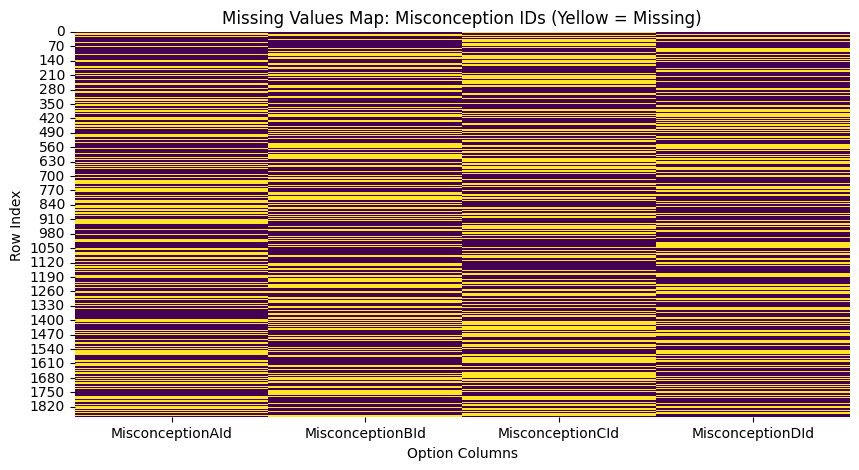

In [ ]:
# Check Missingness (Where do we have labels?)
# We only care about Misconception Columns
misc_cols = ['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']

plt.figure(figsize=(10, 5))
sns.heatmap(df_train[misc_cols].isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Map: Misconception IDs (Yellow = Missing)")
plt.xlabel("Option Columns")
plt.ylabel("Row Index")
plt.show()

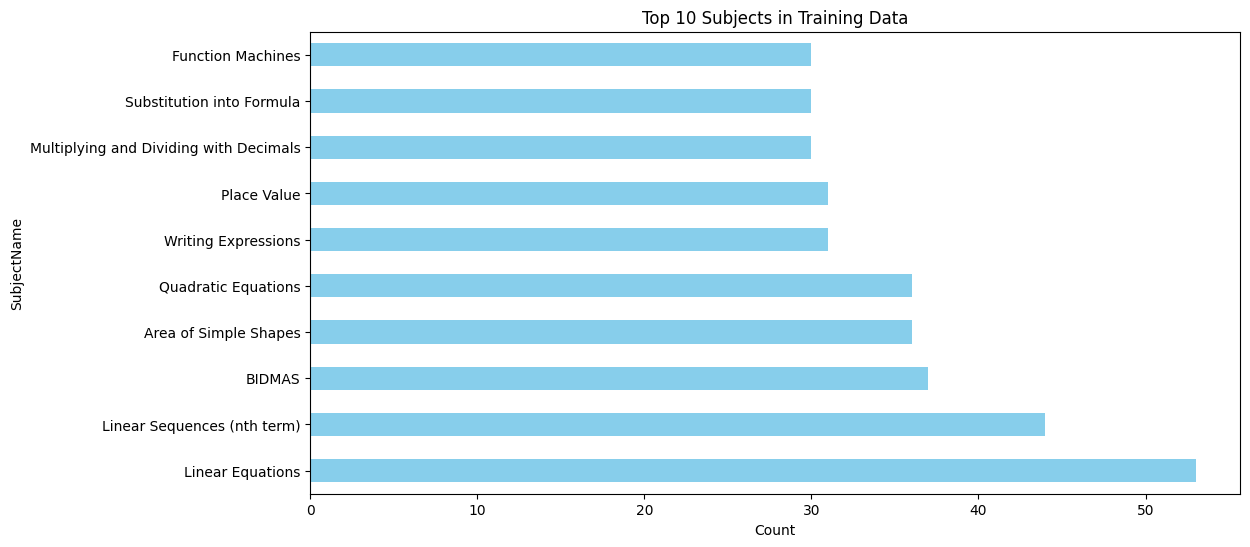

In [ ]:
# Distribution of Subjects (What topics are covered?)
plt.figure(figsize=(12, 6))
df_train['SubjectName'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Subjects in Training Data")
plt.xlabel("Count")
plt.show()

/tmp/ipython-input-2365802356.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CorrectAnswer', data=df_train, order=['A', 'B', 'C', 'D'], palette='pastel')


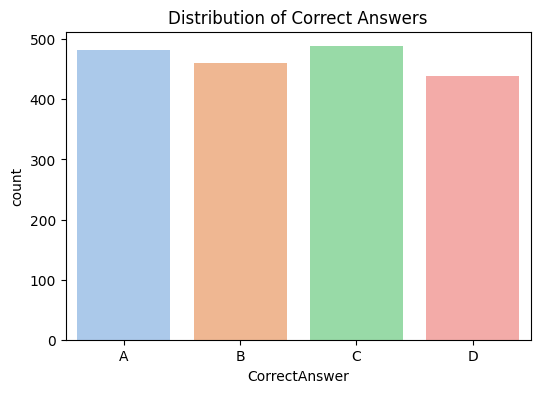

In [ ]:
# Check for Answer Bias (e.g. Is 'C' always the right answer?)
plt.figure(figsize=(6, 4))
sns.countplot(x='CorrectAnswer', data=df_train, order=['A', 'B', 'C', 'D'], palette='pastel')
plt.title("Distribution of Correct Answers")
plt.show()

In [ ]:
df_mapping.head()

,MisconceptionId,MisconceptionName
0,0,Does not know that angles in a triangle sum to...
1,1,Uses dividing fractions method for multiplying...
2,2,Believes there are 100 degrees in a full turn
3,3,Thinks a quadratic without a non variable term...
4,4,Believes addition of terms and powers of terms...


In [ ]:
# We map ID (int) to Name (str)
misc_map = dict(zip(df_mapping['MisconceptionId'], df_mapping['MisconceptionName']))

In [ ]:
# 3. Reshape Data from "Wide" to "Long"
# We want a dataframe with columns: [QuestionText, StudentAnswer, MisconceptionName]
processed_rows = []

for idx, row in df_train.iterrows():
    q_text = row['QuestionText']

    # Iterate through options A, B, C, D
    for letter in ['A', 'B', 'C', 'D']:
        ans_col = f'Answer{letter}Text'
        misc_id_col = f'Misconception{letter}Id'

        # Check if the MisconceptionId is NOT NaN (valid number)
        if pd.notna(row[misc_id_col]):
            misc_id = int(row[misc_id_col])

            # Only proceed if we have the name for this ID
            if misc_id in misc_map:
                processed_rows.append({
                    'QuestionId': row['QuestionId'], # Kept for splitting
                    'QuestionText': q_text,
                    'StudentAnswer': row[ans_col],
                    'Misconception_Name': misc_map[misc_id],
                    'Misconception_Id': misc_id
                })

df_clean = pd.DataFrame(processed_rows)

print(f"Total training pairs created: {len(df_clean)}")

Total training pairs created: 4370


In [ ]:
pd.set_option("display.max_colwidth", None)
df_clean.head()

,QuestionId,QuestionText,StudentAnswer,Misconception_Name,Misconception_Id
0,0,\[\n3 \times 2+4-5\n\]\nWhere do the brackets need to go to make the answer equal \( 13 \) ?,Does not need brackets,"Confuses the order of operations, believes addition comes before multiplication",1672
1,1,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",\( m+1 \),"Does not know that to factorise a quadratic expression, to find two numbers that add to give the coefficient of the x term, and multiply to give the non variable term\n",2142
2,1,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",\( m+2 \),"Thinks that when you cancel identical terms from the numerator and denominator, they just disappear",143
3,1,"Simplify the following, if possible: \( \frac{m^{2}+2 m-3}{m-3} \)",\( m-1 \),"Does not know that to factorise a quadratic expression, to find two numbers that add to give the coefficient of the x term, and multiply to give the non variable term\n",2142
4,2,"Tom and Katie are discussing the \( 5 \) plants with these heights:\n\( 24 \mathrm{~cm}, 17 \mathrm{~cm}, 42 \mathrm{~cm}, 26 \mathrm{~cm}, 13 \mathrm{~cm} \)\nTom says if all the plants were cut in half, the range wouldn't change.\nKatie says if all the plants grew by \( 3 \mathrm{~cm} \) each, the range wouldn't change.\nWho do you agree with?",Only\nTom,Believes if you changed all values by the same proportion the range would not change,1287


In [ ]:
# Class Imbalance
# Count how many times each Misconception appears
misc_counts = df_clean['Misconception_Name'].value_counts()

print(f"Total Unique Misconceptions: {len(misc_counts)}")
print(f"Misconceptions with only 1 sample: {sum(misc_counts == 1)}")
print(f"Misconceptions with < 5 samples: {sum(misc_counts < 5)}")

Total Unique Misconceptions: 1604
Misconceptions with only 1 sample: 747
Misconceptions with < 5 samples: 1389


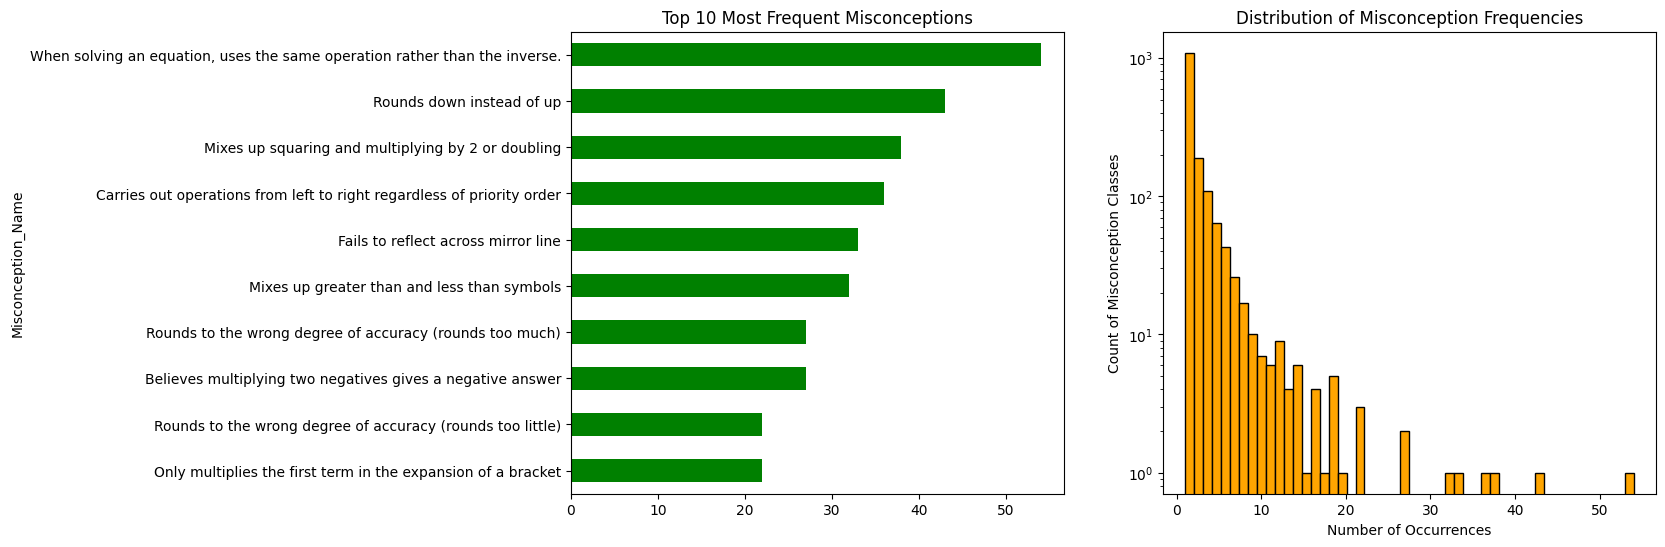

In [ ]:
# Plot the Head vs. Tail
plt.figure(figsize=(14, 6))

# Plot Top 10 Frequent Misconceptions
plt.subplot(1, 2, 1)
misc_counts.head(10).plot(kind='barh', color='green')
plt.title("Top 10 Most Frequent Misconceptions")
plt.gca().invert_yaxis()

# Plot Distribution of Counts (Histogram)
plt.subplot(1, 2, 2)
plt.hist(misc_counts.values, bins=50, color='orange', edgecolor='black')
plt.title("Distribution of Misconception Frequencies")
plt.xlabel("Number of Occurrences")
plt.ylabel("Count of Misconception Classes")
plt.yscale('log') # Log scale helps see the tail
plt.show()

In [ ]:
import torch
import pandas as pd
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
from datasets import Dataset

In [ ]:
# -------------------------------
# Configuration
# -------------------------------
MODEL_CHECKPOINT = "google/flan-t5-large"
MAX_INPUT_LENGTH = 1024
MAX_TARGET_LENGTH = 128
RARE_THRESHOLD = 3
SAMPLES_TO_GENERATE = 2
FEW_SHOT_K = 3

In [ ]:
# -------------------------------
# Few-shot block creation
# -------------------------------
few_shot_df = df_clean.head(FEW_SHOT_K).copy()

def format_example(row):
    instruction = (
        f"Question: {row['QuestionText']}\n"
        f"Misconception: {row['Misconception_Name']}\n"
        f"Task: Generate a plausible but incorrect answer based on the misconception."
    )
    response = row["StudentAnswer"]
    return f"INPUT: {instruction} OUTPUT: {response}\n"

few_shot_block = "".join(format_example(row) for _, row in few_shot_df.iterrows())

In [ ]:
# -------------------------------
# Prompt formatting
# -------------------------------
def format_prompt(row):
    instruction = (
        f"Question: {row['QuestionText']}\n"
        f"Misconception: {row['Misconception_Name']}\n"
        f"Task: Generate a plausible but incorrect answer based on the misconception."
    )
    input_text = f"{few_shot_block}INPUT: {instruction} OUTPUT:"
    return input_text, row["StudentAnswer"]

df_clean[["input_text", "target_text"]] = df_clean.apply(
    lambda r: pd.Series(format_prompt(r)), axis=1
)

# Remove empty targets (critical)
df_clean = df_clean[df_clean["target_text"].str.strip() != ""]

dataset = Dataset.from_pandas(df_clean[["input_text", "target_text"]])


In [ ]:
# -------------------------------
# Load tokenizer & model (ONCE)
# -------------------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# -------------------------------
# Tokenization
# -------------------------------
def preprocess_function(examples):
    inputs = tokenizer(
        examples["input_text"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length"
    )

    labels = tokenizer(
        examples["target_text"],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length"
    )

    # Ignore padding tokens in loss
    labels["input_ids"] = [
        [(tok if tok != tokenizer.pad_token_id else -100) for tok in seq]
        for seq in labels["input_ids"]
    ]

    inputs["labels"] = labels["input_ids"]
    return inputs

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=["input_text", "target_text"]
)

tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42)


Map:   0%|          | 0/4370 [00:00<?, ? examples/s]

In [ ]:
# -------------------------------
# Trainer setup
# -------------------------------
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-misconception-augmentor-fewshot",
    eval_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=2,   # safer for Colab
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=False,
    logging_steps=50,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator
)


In [ ]:
# -------------------------------
# Train
# -------------------------------
print("Starting T5 Training (Colab-safe)...")
trainer.train()
print("Training complete.")

🚀 Starting T5 Training (Colab-safe)...


Epoch,Training Loss,Validation Loss
1,1.049300,0.988249
2,0.854900,0.869964
3,0.721400,0.862781


✅ Training complete.


In [ ]:
# --- Augment Rare Classes ---

# Identify rare misconceptions
counts = df_clean['Misconception_Id'].value_counts()
rare_ids = counts[counts < RARE_THRESHOLD].index.tolist()
print(f"Found {len(rare_ids)} rare misconceptions to augment.")

# Filter dataframe for only rare rows
rare_df = df_clean[df_clean['Misconception_Id'].isin(rare_ids)].copy()


Found 1090 rare misconceptions to augment.


In [ ]:
from tqdm.auto import tqdm
# Setup pipeline for generation
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

synthetic_rows = []

print("Generating synthetic distractors...")
for idx, row in tqdm(rare_df.iterrows(), total=len(rare_df), desc="Generating Variants"):
    input_text = row['input_text']

    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Generate multiple variations using sampling
    # strict decoding (beams) usually gives the 'best' answer,
    # but we want variety (sampling), so we use do_sample=True
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=64,
            do_sample=True,         # Enable sampling for variety
            top_k=50,               # Top-K sampling
            top_p=0.95,             # Nucleus sampling
            temperature=0.7,        # Average temp = mediocre creativity
            num_return_sequences=SAMPLES_TO_GENERATE
        )

    decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Add synthetic data to list
    for pred_ans in decoded_preds:
        synthetic_rows.append({
            'QuestionId': row['QuestionId'], # Keep original QID
            'QuestionText': row['QuestionText'],
            'StudentAnswer': pred_ans,
            'Misconception_Name': row['Misconception_Name'],
            'Misconception_Id': row['Misconception_Id'],
            'Is_Synthetic': True # Helper flag
        })

# --- Merge Data ---

df_synthetic = pd.DataFrame(synthetic_rows)
df_augmented = pd.concat([df_clean, df_synthetic], ignore_index=True)

print(f"Original size: {len(df_clean)}")
print(f"Augmented size: {len(df_augmented)}")

Generating synthetic distractors...


Generating Variants:   0%|          | 0/1433 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors


Original size: 4370
Augmented size: 7236


In [ ]:
df_clean.to_csv("/content/df_clean.csv")
df_synthetic.to_csv("/content/df_synthetic.csv")
df_augmented.to_csv("/content/df_augmented.csv")

In [ ]:
import pandas as pd
df_augmented = pd.read_csv("/content/df_augmented.csv")
# Unique misconception corpus
misconception_df = (
    df_augmented[['Misconception_Id', 'Misconception_Name']]
    .drop_duplicates()
    .reset_index(drop=True)
)

misconception_texts = misconception_df['Misconception_Name'].tolist()
misconception_ids = misconception_df['Misconception_Id'].tolist()

print(f"Total misconceptions: {len(misconception_texts)}")


Total misconceptions: 1604


In [ ]:
def build_query(row):
    return f"Question: {row['QuestionText']} Distractor: {row['StudentAnswer']}"

df_augmented['query_text'] = df_augmented.apply(build_query, axis=1)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=50000,
    stop_words='english'
)

tfidf_misconceptions = tfidf.fit_transform(misconception_texts)


In [ ]:
def sparse_retrieve(query_text, top_k=100):
    q_vec = tfidf.transform([query_text])
    sims = cosine_similarity(q_vec, tfidf_misconceptions)[0]

    top_idx = sims.argsort()[-top_k:][::-1]
    return [misconception_ids[i] for i in top_idx]


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

dense_model = SentenceTransformer("all-distilroberta-v1", device='cuda', trust_remote_code=True)

In [ ]:
misconception_embeddings = dense_model.encode(
    misconception_texts,
    batch_size=64,
    convert_to_numpy=True,
    show_progress_bar=True
)

Batches:   0%|          | 0/26 [00:00<?, ?it/s]

In [ ]:
def dense_retrieve(query_text, top_k=100):
    q_emb = dense_model.encode([query_text], convert_to_numpy=True)
    sims = np.dot(misconception_embeddings, q_emb.T).squeeze()

    top_idx = sims.argsort()[-top_k:][::-1]
    return [misconception_ids[i] for i in top_idx]


In [ ]:
def hybrid_retrieve(query_text, k_sparse=100, k_dense=100, final_k=200):
    sparse_ids = sparse_retrieve(query_text, k_sparse)
    dense_ids = dense_retrieve(query_text, k_dense)

    # Union
    hybrid_ids = list(set(sparse_ids) | set(dense_ids))

    # Optional cutoff
    return hybrid_ids[:final_k]


In [ ]:
candidate_rows = []

for _, row in tqdm(df_augmented.iterrows(), total=len(df_augmented)):
    candidates = hybrid_retrieve(row['query_text'])

    candidate_rows.append({
        "QuestionId": row["QuestionId"],
        "True_Misconception_Id": row["Misconception_Id"],
        "query_text": row["query_text"],          # keep query
        "Candidate_Misconception_Ids": candidates # store once
    })

df_candidates = pd.DataFrame(candidate_rows)


  0%|          | 0/5864 [00:00<?, ?it/s]

In [ ]:
def recall_at_k(df, k=200):
    hits = 0
    for _, row in df.iterrows():
        if row['True_Misconception_Id'] in row['Candidate_Misconception_Ids'][:k]:
            hits += 1
    return hits / len(df)

print("Recall@200:", recall_at_k(df_candidates, 200))


Recall@200: 0.8011596180081856


In [ ]:
from sentence_transformers import CrossEncoder

# Load a pre-trained Cross-Encoder model
rerank_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', device='cuda')

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

In [ ]:
id2text = dict(
    zip(
        misconception_df['Misconception_Id'],
        misconception_df['Misconception_Name']
    )
)

In [ ]:
reranked_data = []

for _, row in tqdm(df_candidates.iterrows(), total=len(df_candidates)):
    query = row['query_text']
    candidate_ids = row['Candidate_Misconception_Ids']

    # Map IDs → texts (FAST: use dict lookup)
    candidate_texts = [id2text[c_id] for c_id in candidate_ids]

    pairs = [[query, text] for text in candidate_texts]

    scores = rerank_model.predict(
        pairs,
        batch_size=128,
        show_progress_bar=False
    )

    ranked_idx = np.argsort(scores)[::-1]
    reranked_ids = [candidate_ids[i] for i in ranked_idx]

    reranked_data.append({
        "QuestionId": row["QuestionId"],
        "True_Misconception_Id": row["True_Misconception_Id"],
        "Reranked_Candidates": reranked_ids
    })

df_reranked = pd.DataFrame(reranked_data)


  0%|          | 0/5864 [00:00<?, ?it/s]

In [ ]:
def evaluate_recall(df, k):
    hits = 0
    for _, row in df.iterrows():
        if row['True_Misconception_Id'] in row['Reranked_Candidates'][:k]:
            hits += 1
    return hits / len(df)

r25 = evaluate_recall(df_reranked, 25)
print(f"Recall@25 after Reranking: {r25:.4f}")

Recall@25 after Reranking: 0.4662


In [ ]:
def recall_at_k_candidates(df, k):
    return sum(
        row["True_Misconception_Id"] in row["Candidate_Misconception_Ids"][:k]
        for _, row in df.iterrows()
    ) / len(df)

def recall_at_k_reranked(df, k):
    return sum(
        row["True_Misconception_Id"] in row["Reranked_Candidates"][:k]
        for _, row in df.iterrows()
    ) / len(df)


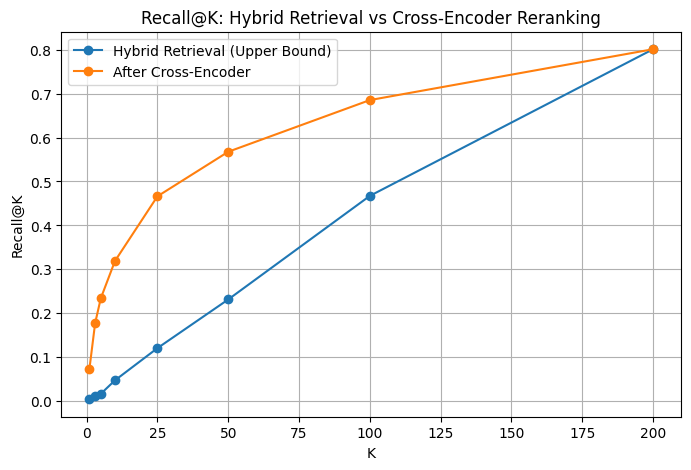

In [ ]:
import matplotlib.pyplot as plt

K_VALUES = [1, 3, 5, 10, 25, 50, 100, 200]

hybrid_recalls = [
    recall_at_k_candidates(df_candidates, k) for k in K_VALUES
]

reranked_recalls = [
    recall_at_k_reranked(df_reranked, k) for k in K_VALUES
]

plt.figure(figsize=(8, 5))
plt.plot(K_VALUES, hybrid_recalls, marker='o', label="Hybrid Retrieval (Upper Bound)")
plt.plot(K_VALUES, reranked_recalls, marker='o', label="After Cross-Encoder")

plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K: Hybrid Retrieval vs Cross-Encoder Reranking")
plt.legend()
plt.grid(True)
plt.show()


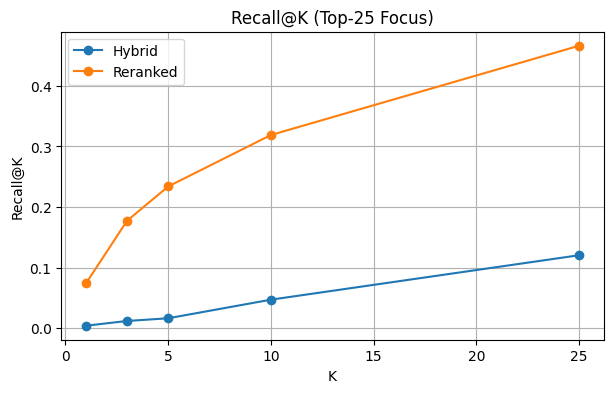

In [ ]:
K_SMALL = [1, 3, 5, 10, 25]

hybrid_small = [
    recall_at_k_candidates(df_candidates, k) for k in K_SMALL
]
reranked_small = [
    recall_at_k_reranked(df_reranked, k) for k in K_SMALL
]

plt.figure(figsize=(7, 4))
plt.plot(K_SMALL, hybrid_small, marker='o', label="Hybrid")
plt.plot(K_SMALL, reranked_small, marker='o', label="Reranked")

plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K (Top-25 Focus)")
plt.legend()
plt.grid(True)
plt.show()


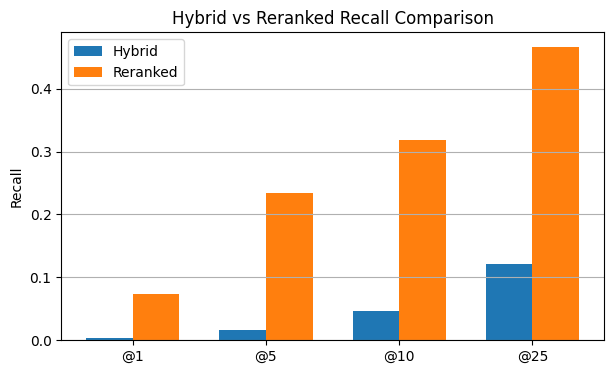

In [ ]:
labels = ["@1", "@5", "@10", "@25"]
hybrid_vals = [recall_at_k_candidates(df_candidates, k) for k in [1,5,10,25]]
rerank_vals = [recall_at_k_reranked(df_reranked, k) for k in [1,5,10,25]]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7, 4))
plt.bar(x - width/2, hybrid_vals, width, label="Hybrid")
plt.bar(x + width/2, rerank_vals, width, label="Reranked")

plt.xticks(x, labels)
plt.ylabel("Recall")
plt.title("Hybrid vs Reranked Recall Comparison")
plt.legend()
plt.grid(axis="y")
plt.show()


In [ ]:
reranked_recalls

[0.07401091405184175,
 0.17735334242837653,
 0.2339699863574352,
 0.3188949522510232,
 0.4662346521145975,
 0.5677012278308322,
 0.685368349249659,
 0.8011596180081856]

In [ ]:
hybrid_recalls

[0.004263301500682128,
 0.012107776261937243,
 0.016541609822646658,
 0.04723738062755798,
 0.12056616643929059,
 0.23141200545702592,
 0.46725784447476126,
 0.8011596180081856]

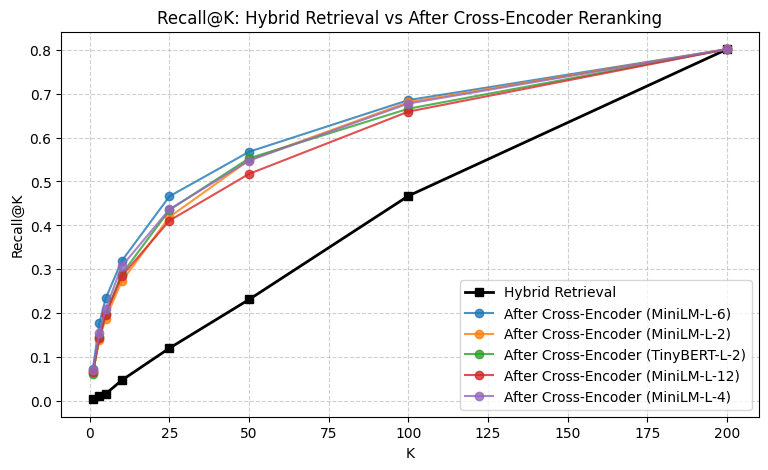

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

K_VALUES = [1, 3, 5, 10, 25, 50, 100, 200]
hybrid_retrieval = [0.00426, 0.01210, 0.01654, 0.04723, 0.12056, 0.23141, 0.46725, 0.80115]

cross_encoders = {
    "MiniLM-L-6": [0.07401, 0.17735, 0.23396, 0.31889, 0.46623, 0.56770, 0.68536, 0.80115],
    "MiniLM-L-2": [0.06531, 0.14017, 0.18775, 0.27251, 0.41916, 0.54877, 0.68076, 0.80115],
    "TinyBERT-L-2": [0.06241, 0.14580, 0.19884, 0.28871, 0.43519, 0.55286, 0.66575, 0.80115],
    "MiniLM-L-12": [0.06667, 0.14427, 0.19696, 0.28444, 0.41098, 0.51739, 0.65910, 0.80115],
    "MiniLM-L-4": [0.07145, 0.15569, 0.21009, 0.30678, 0.43673, 0.54757, 0.67752, 0.80115]
}

# 1. Main Plot
plt.figure(figsize=(9, 5))
plt.plot(K_VALUES, hybrid_retrieval, marker='s', color='black', linewidth=2, label="Hybrid Retrieval")
for model, vals in cross_encoders.items():
    plt.plot(K_VALUES, vals, marker='o', alpha=0.8, label=f"After Cross-Encoder ({model})")

plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K: Hybrid Retrieval vs After Cross-Encoder Reranking")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

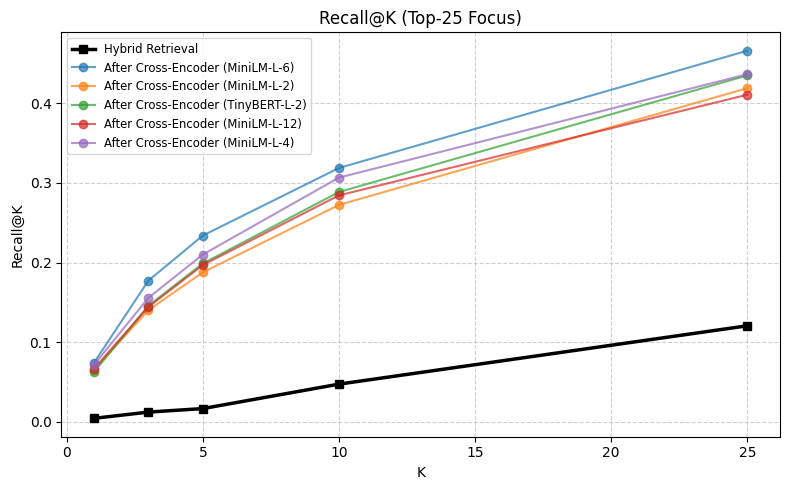

In [ ]:
import matplotlib.pyplot as plt

# Data Setup
K_SMALL = [1, 3, 5, 10, 25]
hybrid_small = [0.00426, 0.01211, 0.01654, 0.04724, 0.12057]

cross_encoders_small = {
    "MiniLM-L-6": [0.07401, 0.17735, 0.23397, 0.31889, 0.46623],
    "MiniLM-L-2": [0.06531, 0.14018, 0.18776, 0.27251, 0.41917],
    "TinyBERT-L-2": [0.06241, 0.14580, 0.19884, 0.28871, 0.43520],
    "MiniLM-L-12": [0.06668, 0.14427, 0.19696, 0.28445, 0.41098],
    "MiniLM-L-4": [0.07145, 0.15570, 0.21010, 0.30679, 0.43673]
}

plt.figure(figsize=(8, 5))

# Plot Hybrid Baseline
plt.plot(K_SMALL, hybrid_small, marker='s', color='black',
         linewidth=2.5, label="Hybrid Retrieval")

# Plot Cross-Encoders
for label, values in cross_encoders_small.items():
    plt.plot(K_SMALL, values, marker='o', alpha=0.7,
             label=f"After Cross-Encoder ({label})")

plt.xlabel("K")
plt.ylabel("Recall@K")
plt.title("Recall@K (Top-25 Focus)")
plt.legend(loc='upper left', fontsize='small')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

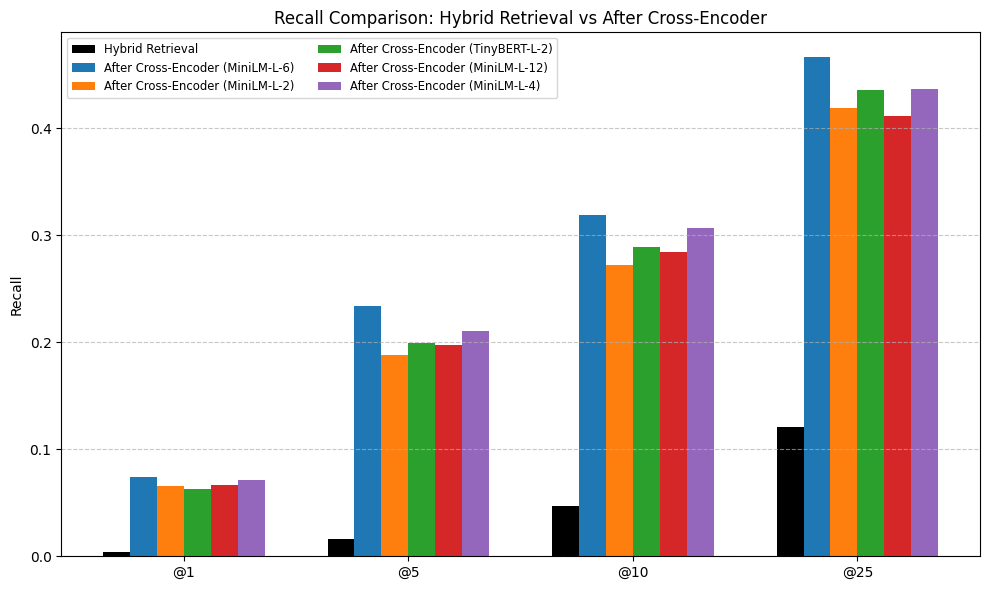

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Select specific indices for @1, @5, @10, @25
labels = ["@1", "@5", "@10", "@25"]
indices = [0, 2, 3, 4]

hybrid_vals = [0.00426, 0.01654, 0.04724, 0.12057]
ce_data = {
    "MiniLM-L-6": [0.07401, 0.23397, 0.31889, 0.46623],
    "MiniLM-L-2": [0.06531, 0.18776, 0.27251, 0.41917],
    "TinyBERT-L-2": [0.06241, 0.19884, 0.28871, 0.43520],
    "MiniLM-L-12": [0.06668, 0.19696, 0.28445, 0.41098],
    "MiniLM-L-4": [0.07145, 0.21010, 0.30679, 0.43673]
}

x = np.arange(len(labels))
width = 0.12  # Width of individual bars

plt.figure(figsize=(10, 6))

# Plot Hybrid Bar
plt.bar(x - (width * 2.5), hybrid_vals, width, label="Hybrid Retrieval", color='black')

# Plot Cross-Encoder Bars with shifts
for i, (model, values) in enumerate(ce_data.items()):
    plt.bar(x - (width * 1.5) + (i * width), values, width,
            label=f"After Cross-Encoder ({model})")

plt.xticks(x, labels)
plt.ylabel("Recall")
plt.title("Recall Comparison: Hybrid Retrieval vs After Cross-Encoder")
plt.legend(loc='upper left', fontsize='small', ncol=2) # 2 columns to save space
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()